In [22]:
!pip install networkx

In [23]:
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt

### Introduction to the Project
In this project, we aim to replicate and extend the findings of the paper "From Louvain to Leiden: guaranteeing well-connected communities". The paper critiques the widely-accepted Louvain community detection algorith by highlighting its underlying risk of producing disconnected communities and its relatively slow performance. Our project objectives are implementing both the Louvain and Leiden models, and comparing their modularity and speed to conclude that the Leiden algorithm outperforms the Louvain algorithm in terms of intra-community connectivity and model efficiency.

To test the functionality of both models, we will first utilize the well-known "Zachary's Karate Club" graph dataset from the Python library NetworkX. Furthermore, we will extend the original paper's analysis by evaluating the performance of the two models on real-world networks such as the Reddit network data, and comparing them with the Barabási–Albert model we learned in class.

##### Data

In [24]:
G = nx.karate_club_graph()

### Louvain Algorithm Implementation

The Louvain algorithm is a popular method for community detection in large networks. It is named after the University of Louvain, where it was developed. The algorithm is known for its efficiency and simplicity, making it suitable for analyzing large-scale networks.

The architecture of the Louvain algorithm is based on a hierarchical clustering approach, which operates in two main phases that are repeated iteratively:

1. **Modularity Optimization:** The algorithm first assigns nodes to communities in a way that maximizes the modularity of the network. Modularity is the quality function for this model. It quantifies the density of connections within communities compared to connections between communities. The algorithm starts with each node in its own community and then, for each node, it evaluates the gain in modularity that would result from moving the node to the community of each of its neighbors. If a move increases the modularity, the step is
 performed. The whole process is repeated for all nodes until no further improvement in modularity can be achieved.

2. **Community Aggregation:** Once the first phase is complete, the algorithm creates a new network where each community from the previous phase is seen as a large "node". The weights of the edges between these newly formed large nodes are equal to the sum of the weights of the edges between nodes in the corresponding communities. The algorithm then applies the modularity optimization phase again on this aggregated network.

These two phases are repeated iteratively until the modularity cannot be increased further, indicating that the optimal community structure has been found.

The functions below implement the Louvain algorithm.

In [25]:
def singleton_partition(G):
    """
    Create a partition where each node is in its own community.

    Args:
        G: The graph that will be partitioned.

    Returns:
        set of frozensets: A partition of the graph where each node is in its own singleton community.
    """
    return {frozenset({v}) for v in G.nodes()}

In [26]:
P = singleton_partition(G)

In [27]:
class Graph:
    """
    Represents a graph with a set of nodes and edges.

    Attributes:
        nodes (set): The set of nodes in the graph.
        edges (set): The set of edges in the graph, where each edge is represented as a tuple (node1, node2).
    """

    def __init__(self, nodes, edges):
        """
        Initializes a new Graph object.

        Args:
            nodes (set): The set of nodes for the graph.
            edges (set): The set of edges for the graph, where each edge is represented as a tuple (node1, node2).
        """
        self.nodes = nodes
        self.edges = edges

    def __repr__(self):
        """
        Returns a string representation of the graph.
        """
        return f"Graph(nodes={self.nodes}, edges={self.edges})"

    def draw(self):
        """
        Draws the graph using NetworkX and Matplotlib, displaying only the numbers for each node label.
        """
        G = nx.Graph()
        # Create a mapping from frozenset nodes to numbers
        node_labels = {node: list(node)[0] for node in self.nodes}
        G.add_nodes_from(node_labels.values())
        G.add_edges_from([(node_labels[u], node_labels[v]) for u, v in self.edges])
        nx.draw(G, with_labels=True, node_color='lightblue')
        plt.show()



In [28]:
def aggregate_graph(G, P):
    """
    Creates an aggregate graph where each community in the partition becomes a node, and an edge is added between two nodes
    if there is at least one edge between the corresponding communities in the original graph.

    Args:
        G (graph): The original graph.
        P (set): The partition of the graph.

    Returns:
        Graph: The aggregate graph.
    """
    V = P
    E = set()
    for (u, v) in G.edges:
        for C in P:
            for D in P:
                if u in C and v in D:
                    E.add((C, D))
    return Graph(V, E)

In [29]:
agg_graph = aggregate_graph(G,P)

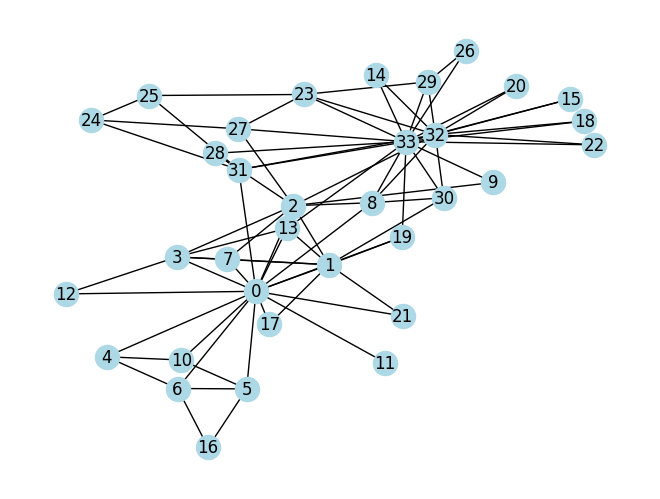

In [30]:
agg_graph.draw()

Since this is the aggregate graph after single partition, the number on each node simply indicates the index of the node encoded in the original graph.

P (the partition) is a dictionary with int keys K representing nodes in the network and int values V representing the communities they belong to.

In [31]:
import numpy as np

# num of edges between community C and community D, for instance
def get_edges_between_two_comms(comm1, comm2, G, P):
    res = 0
    # Convert the set of frozensets to a dictionary
    P_dict = {node: comm for comm in P for node in comm}
    members1 = [node for node in G.nodes if P_dict[node] == comm1]
    members2 = [node for node in G.nodes if P_dict[node] == comm2]
    for node in members1:
        res += len(set(members2) & set(G[node]))
    return res

def get_edges_between_communities(G, P):
    counts = {}
    for i, k1 in enumerate(P):
        for j, k2 in enumerate(P):
            if i <= j:
                counts[k1, k2] = get_edges_between_two_comms(k1, k2, G, P)
    return counts

def H(G, P, gamma=1/7):
    total = 0
    counts = get_edges_between_communities(G, P)  # E(C,D) in the paper
    for comm in P:
        comm_size = len(comm)
        total += counts[comm, comm] - (gamma * math.comb(comm_size, 2))
    return total

def maybe_move_node(node, community, P):
    P_new = set()
    node_moved = False
    for comm in P:
        if node in comm and comm != community:
            P_new.add(comm - {node})
        else:
            P_new.add(comm)
    for comm in P_new:
        if comm == community:
            P_new.remove(comm)
            P_new.add(comm | {node})
            node_moved = True
            break
    if not node_moved:
        P_new.add(frozenset({node}))
    return P_new


def move_node(node, community, P):
    P_new = set()
    node_moved = False
    for comm in P:
        if node in comm and comm != community:
            P_new.add(comm - {node})
        else:
            P_new.add(comm)
    for comm in P_new:
        if comm == community:
            P_new.remove(comm)
            P_new.add(comm | {node})
            node_moved = True
            break
    if not node_moved:
        P_new.add(frozenset({node}))
    return P_new


def move_nodes(G, P, gamma=1/7):
    H_old = H(G, P, gamma)
    improvement = True
    while improvement:
        improvement = False
        for node in G.nodes():
            best_community = None
            best_increase = 0
            for community in P.union({frozenset()}):
                P_new = maybe_move_node(node, community, P)
                increase = H(G, P_new, gamma) - H_old
                if increase > best_increase:
                    best_increase = increase
                    best_community = community
            if best_increase > 0:
                P = move_node(node, best_community, P)
                H_old = H(G, P, gamma)
                improvement = True
    return P


In [32]:
#get_edges_between_communities(G, P)

In [33]:
H(G, P, gamma=1/7)

0.0

In [34]:
move_nodes(G, P)

{frozenset(),
 frozenset({4, 5, 6, 10, 16}),
 frozenset({24, 25, 28, 31}),
 frozenset({0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21}),
 frozenset({8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33})}

In [35]:
def draw_partitioned_graph(G, P):
    pos = nx.spring_layout(G)  # Positions for all nodes

    # Create a mapping from nodes to communities
    node_to_community = {node: comm for comm in P for node in comm}

    # Assign colors based on communities
    colors = [hash(node_to_community[node]) % 256 for node in G.nodes()]

    nx.draw(G, pos, node_color=colors, with_labels=True)
    plt.show()

In [36]:
def flattened(P):
    return set(frozenset.union(*P))

def Louvain(G, P):
    done = False
    iteration = 0
    while not done:
        P = move_nodes(G, P)
        print(f"Iteration {iteration}:")
        draw_partitioned_graph(G, P)
        done = len(P) == len(G.nodes())  # Terminate when each community consists of only one node
        if not done:
            G = aggregate_graph(G, P)
            P = singleton_partition(G)
        iteration += 1
    return flattened(P)

#### final partition of the network based on louvain

Iteration 0:


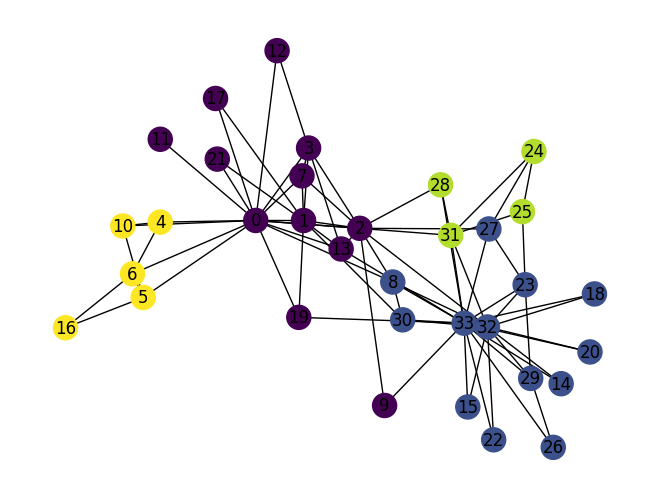

TypeError: 'set' object is not callable

In [37]:
Louvain(G, P)

The Louvain algorithm lacks a mechanism to repair intra-disconnected communities. As a result, repeatedly applying the Louvain algorithm can be a double-edged sword: it may improve the community structure in some respects, but it can also lead to the deterioration of community cohesion.Furthermore, the presence of disconnected communities is just an extremity of a more general problem: communities detected by Louvain can be poorly connected in various degrees.

### Leiden Algorithm Implementation

The Leiden algorithm addresses the issue of disconnected communities present in the Louvain algorithm by introducing several enhancements. It speeds up the local moving of nodes and incorporates the concept of moving nodes to random neighbors. These improvements are considered among the most promising directions for enhancing the Louvain algorithm, although other suggestions have been made as well.

The Leiden algorithm comprises three phases: (1) local moving of nodes, (2) refinement of the partition, and (3) aggregation of the network based on the refined partition. It starts with a singleton partition and moves individual nodes between communities to find a better partition. This partition is then refined to optimize community cohesion. Unlike the Louvain algorithm, the Leiden algorithm includes an extra step of fine-tuning the groups for optimization.

An aggregate network is then created based on the refined partition, using the non-refined partition to create an initial partition for the aggregate network. The algorithm continues by moving individual nodes in the aggregate network, creating subgroups from the original groups, not the refined ones. In some cases, the refinement does not change the partition. These steps are repeated until no further improvements can be made, resulting in a more cohesive and well-connected community structure.

The punchline of Leiden is its refinement phase. Communities that are already defined during the initial partitioning phase may be further split into multiple sub communities during the refining phase. By creating the aggregate network based on refined partitioning rather than the original partitioning, the Leiden algorithm has more room for identifying high-quality partitions.

Importatnly, in the refinement phase, nodes are not necessarily greedily merged with the community that yields the largest increase in the quality function. Instead, a node may be merged with any community for which the quality function increases. Randomness in the selection of a community allows the partition space to be explored more broadly. Node mergers that cause the quality function to decrease are not considered, yielding this model more efficient than Louvain.

The functions below implement the Leiden algorithm. Note that the first two steps of leiden are exactly the same as louvain

These are the helper functions:

In [ ]:
def flatten_partition(P):
    return set(frozenset.union(*P))

def modularity(G, P):
    """
    Calculates the modularity of a partition of a graph.

    Args:
        G (Graph): The graph.
        P (set): The partition of the graph, where each element is a set representing a community.

    Returns:
        float: The modularity of the partition.
    """
    m = len(G.edges)
    modularity_value = 0
    for C in P:
        L_C = sum(1 for (u, v) in G.edges if u in C and v in C)
        D_C = sum(sum(1 for (_, v) in G.edges if v in C) for node in C)
        modularity_value += (L_C / m) - (D_C / (2 * m)) ** 2
    return modularity_value

def partition_quality_change(G, P, v, C):
    """
    Calculates the change in modularity when moving a node to a different community.

    Args:
        G (Graph): The graph.
        P (set): The current partition of the graph.
        v (frozenset): The node to be moved.
        C (frozenset): The community to which the node will be moved.

    Returns:
        float: The change in modularity.
    """
    # Find the community that currently contains v
    current_community = next(comm for comm in P if v in comm)

    # Create a new partition without v in its current community
    new_partition = P.copy()
    new_partition.remove(current_community)
    new_partition.add(current_community - {v})

    # Add v to the target community C
    if C in new_partition:
        new_partition.remove(C)
        new_partition.add(C.union({v}))
    else:
        new_partition.add(frozenset({v}))

    current_modularity = modularity(G, P)
    new_modularity = modularity(G, new_partition)
    return new_modularity - current_modularity


In [ ]:
gamma = 0.5
# the resolution parameter, controls the size of the communities detected by the algorithm.
# A higher value of gamma tends to result in smaller, more tightly-knit communities, while a
# lower value tends to produce larger, more inclusive communities.

# In the paper "For each network, we repeated the experiment 10 times. We used modularity with a
# resolution parameter of γ = 1 for the experiments."

theta = 0.1
# higher value of theta increases the likelihood of accepting moves that result in a smaller
# increase in partition quality, thereby introducing more randomness into the process.

def merge_nodes_subset(G, P, S):
    """
    Refines a given partition of a graph by merging well-connected nodes within a specified subset into communities.

    Args:
        G (dict): The graph inputted, where keys are nodes and values are dictionaries
                  of neighboring nodes with edge weights.
        P (dict): The current partition of the graph, where keys are nodes and values are communities.
        S (set): The subset of nodes within which to merge well-connected nodes.

    Returns:
        dict: The updated partition of the graph after merging well-connected nodes within the subset.
    """
    # Calculate the degree of each node and the subset
    k = {v: len(G[v]) for v in S}
    k_S = sum(k.values())

    # Consider only nodes that are well connected within the subset
    R = {v for v in S if sum(1 for u in G[v] if u in S and u != v) >= gamma * k[v] * (k_S - k[v])}

    for v in R:
        # Consider only nodes that are in singleton communities
        if frozenset({v}) in P:
            # Consider only well-connected communities
            T = {C for C in P if C.issubset(S) and
                 sum(1 for u in C for w in S - C if w in G[u]) >= gamma * sum(k[u] for u in C) * (k_S - sum(k[u] for u in C))}

            # Choose a random community to move the node to, based on a probability proportional to the change in partition quality
            delta_hp = {C: partition_quality_change(G, P, v, C) for C in T}
            prob = {C: np.exp(1 / theta * delta_hp[C]) if delta_hp[C] >= 0 else 0 for C in T}
            total_prob = sum(prob.values())
            if total_prob > 0:
                prob = {C: p / total_prob for C, p in prob.items()}
                chosen_community = np.random.choice(list(T), p=list(prob.values()))
                # Update P by removing v from its current community and adding it to the chosen community
                P = {C - {v} if v in C else C for C in P}
                P.add(chosen_community | {v})

    return P

In [ ]:
def refine_partition(G, P):
    prefinined = singleton_partition(G)
    for C in P:
        prefinined = merge_nodes_subset(G, prefinined, C)
    return prefinined

def move_nodes_fast(G, P):
    """
    Moves nodes to different communities to improve the partition quality of the graph.

    Args:
        G (Graph): The graph for which the partition is being optimized.
        P (set): The current partition of the graph, where each element is a set representing a community.

    Returns:
        set: The optimized partition of the graph.
    """
    Q = list(G.nodes)
    while Q:
        v = Q.pop(0)
        best_delta = 0
        best_community = None
        for C in P.union({frozenset()}):
            delta = partition_quality_change(G, P, v, C)
            if delta > best_delta:
                best_delta = delta
                best_community = C
        if best_delta > 0:
            # Find the community that currently contains v
            current_community = next(comm for comm in P if v in comm)
            # Update the partition
            P.remove(current_community)
            P.add(current_community - {v})
            if best_community in P:
                P.remove(best_community)
                P.add(best_community.union({v}))
            else:
                P.add(frozenset({v}))
            # Update the queue
            N = {u for (u, _) in G.edges if u not in best_community}
            Q.extend(list(N - set(Q)))
    return P


def Leiden(G, initial_partition=None):
    """
    Executes the Leiden algorithm to detect communities in a graph.

    Args:
        G (Graph): The graph for which communities are to be detected.
        initial_partition (set, optional): An initial partition of the graph. If not provided, a singleton
            partition is used as the starting point.

    Returns:
        set: The final partition of the graph, where each element is a set representing a community.
    """
    if initial_partition is None:
        P = singleton_partition(G)
    else:
        P = initial_partition
    done = False
    while not done:
        P = move_nodes_fast(G, P)
        done = len(P) == len(G.nodes)
        if not done:
            prefinined = refine_partition(G, P)
            G = aggregate_graph(G, prefinined)
            P = {frozenset({v for v in C if v in G.nodes}) for C in P}
    return flatten_partition(P)

Since the data size in Zachary's karate club is pretty small, the subset we will input into the "merge_nodes_subset" function is the high-degree nodes. We set the threshold to be 4, given that there are only 34 nodes in the network. For future implementation of a much larger network, like the Reddit network data, we will set the threshold higher.

In [ ]:
S = {node for node, degree in G.degree() if degree >= 3}


In [ ]:
merge_nodes_subset(G, P, S)

In [ ]:
P_refined = refine_partition(G, P)

In [ ]:
move_nodes_fast(G, P)

In [ ]:
final_Leiden_partition = Leiden(G, P)

In [ ]:
final_Leiden_partition_draw = {frozenset({node}) for node in final_Leiden_partition}

In [ ]:
draw_partitioned_graph(G, final_Leiden_partition_draw)

Get Reddit data to make graphs with

In [ ]:
import requests
client_id = 'jQmamVd00JTKNBS8De5Rhg'
client_secret = 'LgkFQSkoGPSU9PSYiYZOKACNW26fpQ'

auth = requests.auth.HTTPBasicAuth(client_id, client_secret)

data = {'grant_type' : 'password',
        'username' : 'Crazy-Fishing-2647',
        'password' : '123Summer!'}
headers = {
        "User-Agent": "louvain-leiden/0.1"  # Provide a unique user-agent string
    }

res = requests.post('https://www.reddit.com/api/v1/access_token', auth=auth, data=data, headers=headers)
# print(dir(res))
# print(res._content)
token = res.json()['access_token']
# print(token)

headers = {**headers, **{'Authorization' : f'bearer {token}'}}
print(headers)

def get_subreddit_contributors(subreddit, headers):
    url = f"https://oauth.reddit.com/r/{subreddit}/about/contributors.json"


    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        contributors = response.json()["data"]["children"]
        contributor_names = [contrib["name"] for contrib in contributors]
        return contributor_names
    else:
        print(f"Error: {response.status_code}")
        return None


# Example usage
subreddit = "askscience"
contributors = get_subreddit_contributors(subreddit, headers)
if contributors:
    print(f"Contributors of r/{subreddit}: {', '.join(contributors)}")
    # print(contributors)
else:
    print("Failed to retrieve contributors.")